In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ploting_helper
import reading_helper

%load_ext autoreload
%autoreload 2

In [2]:
# analyzer = reading_helper.toolbox()
# analyzer.conver_to_panel_data("trj_panel_data.csv")

analyzer = reading_helper.toolbox()
analyzer.read_panel_data("trj_panel_data.csv")
df = analyzer.panel_data

# #next has to read file into attribute first
# analyzer.conver_to_average_panel_data("trj_average_panel_data.csv", samplingFrequency=100)

analyzer.read_average_panel_data("trj_average_panel_data.csv")
adf = analyzer.average_panel_data

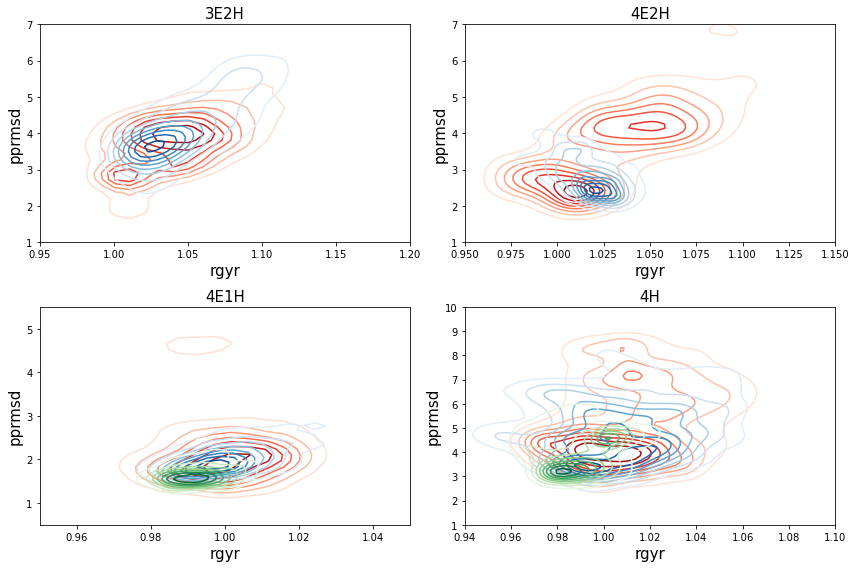

In [9]:
fig = plt.figure(figsize=(12,8))
param_x = "rgyr"
param_y = "pprmsd"

for ptype, i in zip(["3E2H", "4E2H", "4E1H", "4H"], range(4)):
    
    ax = fig.add_subplot(2,2,i+1)
    ploting_helper.plot_2d_density(df, ptype, param_x, param_y, level=8)
    
fig.tight_layout()
plt.savefig(param_x + "-" + param_y + "-density.jpg")
plt.show()

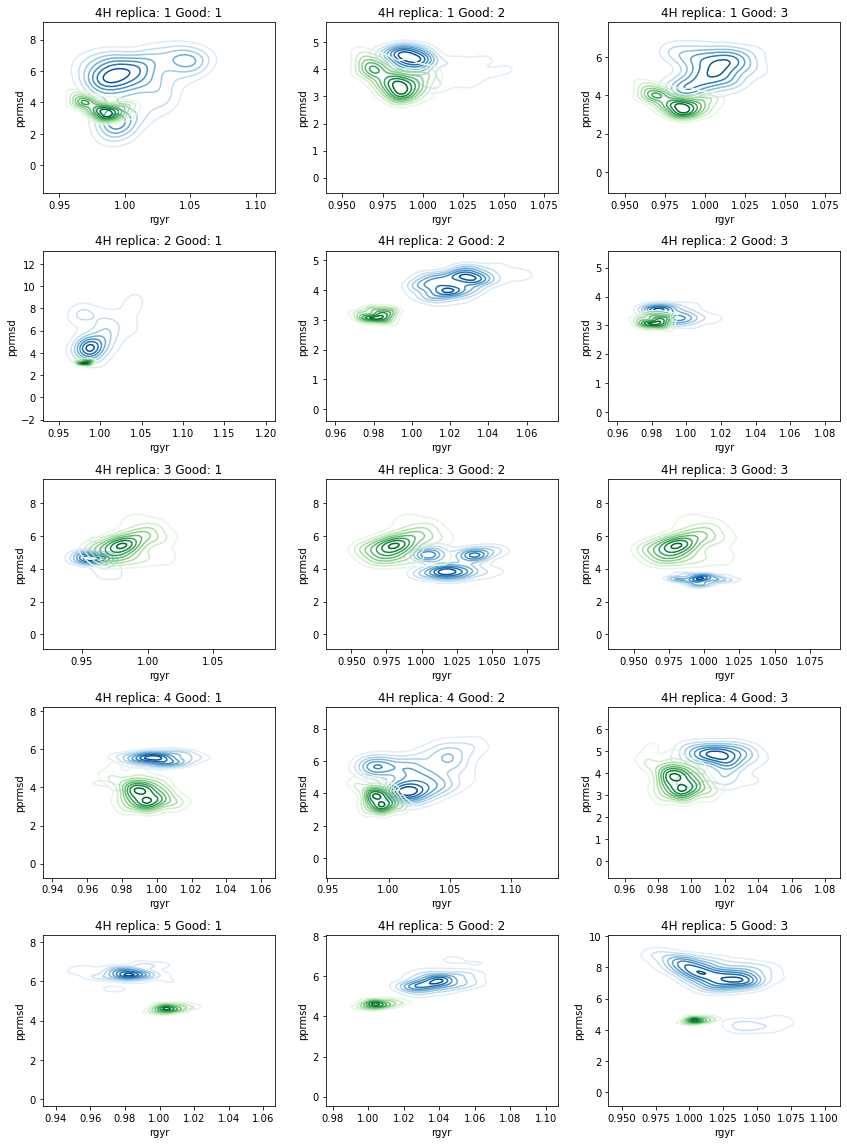

In [18]:
fig = plt.figure(figsize=(12,16))

param_x = "rgyr"
param_y = "pprmsd"
replica = "2"
ptype = "4H"
level = 8

for r in range(5):
    for i in range(3):

        ax = fig.add_subplot(5, 3, 3*(r)+i+1)

        x = df[df.index.str.contains("r_" + str(r+1) + "_" + ptype + "_g_" + str(i+1),regex=True)][param_x]
        y = df[df.index.str.contains("r_" + str(r+1) + "_" + ptype + "_g_" + str(i+1),regex=True)][param_y]
        sns.kdeplot(x[0:-1:10],y[0:-1:10], cmap="Blues", levels=level)

        x = df[df.index.str.contains("r_" + str(r+1) + "_" + ptype + "_c",regex=True)][param_x]
        y = df[df.index.str.contains("r_" + str(r+1) + "_" + ptype + "_c",regex=True)][param_y]
        sns.kdeplot(x[0:-1:10],y[0:-1:10], cmap="Greens", levels=level)

        plt.title(ptype + " replica: " + str(r+1) + " Good: " + str(i+1))
#         plt.xlim(12, 14)
#         plt.ylim(2,10)
    
fig.tight_layout()
plt.savefig(ptype + "-" +param_x + "-" + param_y + "-pprmsd_gc-compare.jpg")
plt.show()

In [4]:
from sklearn.svm import SVC

def svm_analysis(X_train, Y_train, X_val, Y_val, svclassifier):

    svclassifier.fit(X_train, Y_train)
    acc_val  = np.where(svclassifier.predict(X_val) == Y_val, 1, 0)

    return np.mean(acc_val)

def split_by_trajectory(adf, total_duration, valID, testID):
    
    X_train = adf[~adf["type"].str.contains("r_" + str(valID) + "|r_" + str(testID))]
    X_train = X_train[(X_train["time"] < total_duration)].drop(["time", "type"], axis=1)
    
    X_val = adf[adf["type"].str.contains("r_" + str(valID))].drop(["time", "type"], axis=1)
    X_test = adf[adf["type"].str.contains("r_" + str(testID))].drop(["time", "type"], axis=1)
    
    Y_train = X_train.pop("label")
    Y_val = X_val.pop("label")
    Y_test = X_test.pop("label")
    
    return X_train.values, Y_train.values, X_val.values, Y_val.values, X_test.values, Y_test.values

def fourFoldCV(adf, total_duration, svclassifier):
    
    result = []

    for i in range(1,5):
        # split the dataset by trajectories
        X_train, Y_train, X_val, Y_val, X_test, Y_test = split_by_trajectory(adf, total_duration, valID=i, testID=5)
        result.append(svm_analysis(X_train, Y_train, X_val, Y_val, svclassifier))
        
    result = np.array(result)    
    
    return result.mean(), result.std()

In [9]:
# simple grid search for best model
result = {}

for kernel in ["rbf", "poly", "linear"]:
    result[kernel] = []
    for C in [1e-1, 1e0, 1e1, 1e2, 1e3]:
        
        svclassifier = SVC(kernel=kernel, gamma='scale', C=C)
        val_acc, val_std = fourFoldCV(adf, 5000, svclassifier)
        result[kernel].append([C, val_acc, val_std])

In [ ]:
kernel = "poly"
a = np.array(result[kernel])

plt.figure(figsize=(8,6))
plt.plot(a[:,0], a[:,1], '-o', c='k', label=kernel+' kernel')
plt.fill_between(a[:,0], a[:,1]-a[:,2]/2, a[:,1]+a[:,2]/2, color='tab:red') 

plt.title("SVM with sampling freq = 100 ns", fontsize=15)
plt.xlabel("Regularization Parameter C", fontsize=15)
plt.ylabel("Validation Accuracy", fontsize=15)
plt.ylim(0.5, 0.8)
plt.xscale('log')
plt.legend(fontsize=15)

plt.savefig("svm-" + kernel + "-result.jpg")

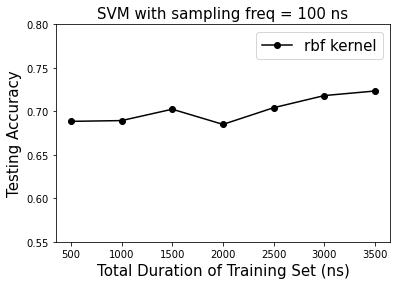

In [5]:
# apply best model 
result = []
svclassifier = SVC(kernel='rbf', gamma='scale', C=1e3)

for total_duration in [500, 1000, 1500, 2000, 2500, 3000, 3500]:
    X_train, Y_train, _, _, X_test, Y_test = split_by_trajectory(adf, total_duration, valID=5, testID=5)
    result.append([total_duration, svm_analysis(X_train, Y_train, X_test, Y_test, svclassifier)])

result = np.array(result)

plt.plot(result[:,0], result[:,1], '-o', c='k', label='rbf kernel')
plt.title("SVM with sampling freq = 100 ns", fontsize=15)
plt.xlabel("Total Duration of Training Set (ns)", fontsize=15)
plt.ylabel("Testing Accuracy", fontsize=15)
plt.ylim(0.55, 0.8)
plt.legend(fontsize=15)
plt.savefig("svm-best-result.jpg")

In [96]:
analyzer = reading_helper.toolbox()

In [12]:
# analyzer = reading_helper.toolbox()
# analyzer.conver_to_panel_data(filename = "4e2h_trj_panel_data.csv")

analyzer = reading_helper.toolbox()
analyzer.read_panel_data("4e2h_trj_panel_data.csv")
df = analyzer.panel_data

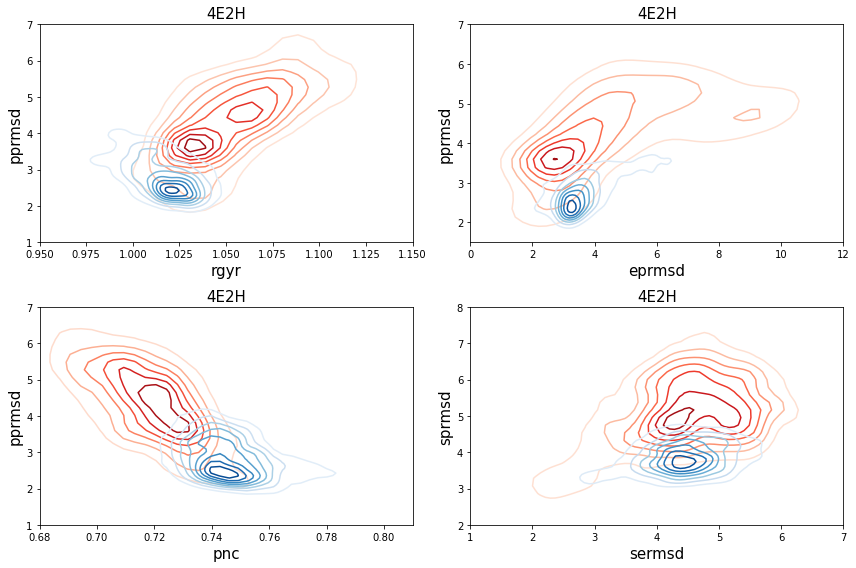

In [13]:
fig = plt.figure(figsize=(12,8))

for param_x, param_y, i in zip(["rgyr", "eprmsd", "pnc", "sermsd"], ["pprmsd", "pprmsd", "pprmsd", "sprmsd"], range(4)):
    
    ax = fig.add_subplot(2,2,i+1)
    ploting_helper.plot_2d_density(df, "4E2H", param_x, param_y, level=8)
    
fig.tight_layout()
plt.savefig("4e2h-deteriorated-density.jpg")
plt.show()